In [1]:
from langchain_community.retrievers import WikipediaRetriever
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langchain.chat_models import init_chat_model

from pydantic import BaseModel, Field
from typing import List
from langchain.agents import create_agent
from langchain.agents.structured_output import ToolStrategy

/Users/sulbhajain/Documents/Personal/genAI_projects/langgraph_agents/lang_env/lib/python3.14/site-packages/langchain_core/_api/deprecation.py:26: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.fields import FieldInfo as FieldInfoV1


In [2]:
# load .env file
from dotenv import load_dotenv
load_dotenv()

True

In [10]:
@tool
def fetch_wikipedia_content(query: str, max_docs: int= 1) -> str:
    """Fetches Wikipedia article content based on the search query."""
    retriever =WikipediaRetriever(load_max_docs=max_docs,
    doc_content_chars_max=5000)
    docs = retriever.invoke(query)
    if not docs:
        return f"No Wikipedia articles found for query: {query}"
    return docs[0].page_content

@tool
def create_summary(text: str, focus: str = "general")-> str:
    """Creates a concise summary of the given text with a specified focus."""
   
    llm = init_chat_model(model="claude-3-7-sonnet-20250219", temperature=0.3)
    prompt = f"Please provide a {focus} summary of the following text... {text}"
    response = llm.invoke(prompt)
    return response.content

In [12]:


class DeepResearchResult(BaseModel):
    """Structured output containing document title,summary, tags, and paragraph count."""
    title: str = Field(description="The title of the document")
    summary: str = Field(description="A comprehensive summary of the document content")
    tags: List[str] = Field(description="A list of relevant tags or keywords")
    total_paragraphs: int = Field(description="The total number of paragraphs in the document")

agent = create_agent(
        model="claude-3-7-sonnet-20250219",
        tools=[fetch_wikipedia_content, create_summary],
        response_format=ToolStrategy(DeepResearchResult),
        system_prompt="You are a helpful Wikipedia research assistant...",
        )

initial_state = {"messages": [HumanMessage(content="Research cognitive behavioral therapy")]}
for event in agent.stream(initial_state):
    # Process and print each step
    print(event)    

{'model': {'messages': [AIMessage(content=[{'id': 'toolu_01YNUEtakyUCUJNxtKmBWMer', 'input': {'query': 'Cognitive behavioral therapy'}, 'name': 'fetch_wikipedia_content', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01V9HQ7cp36oPMfwkaLGRCzY', 'model': 'claude-3-7-sonnet-20250219', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 660, 'output_tokens': 43, 'server_tool_use': None, 'service_tier': 'standard'}, 'model_name': 'claude-3-7-sonnet-20250219', 'model_provider': 'anthropic'}, id='lc_run--019b4e99-5732-7b51-aab4-44902a8eb016-0', tool_calls=[{'name': 'fetch_wikipedia_content', 'args': {'query': 'Cognitive behavioral therapy'}, 'id': 'toolu_01YNUEtakyUCUJNxtKmBWMer', 'type': 'tool_call'}], usage_metadata={'input_tokens': 660, 'output_tokens': 43, 'total_tokens': 703, 'input_token_de

In [13]:
initial_state = {"messages": [HumanMessage(content="Sulbha Jain biography")]}
for event in agent.stream(initial_state):
    # Process and print each step
    print(event)    

{'model': {'messages': [AIMessage(content=[{'id': 'toolu_014VW94cu8ZZR4sA7hMsuftr', 'input': {'query': 'Sulbha Jain'}, 'name': 'fetch_wikipedia_content', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01CXrHeWMPewoNUGiwEKGK8R', 'model': 'claude-3-7-sonnet-20250219', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 664, 'output_tokens': 46, 'server_tool_use': None, 'service_tier': 'standard'}, 'model_name': 'claude-3-7-sonnet-20250219', 'model_provider': 'anthropic'}, id='lc_run--019b4e99-dfc6-7d01-a97a-765ddf1941ea-0', tool_calls=[{'name': 'fetch_wikipedia_content', 'args': {'query': 'Sulbha Jain'}, 'id': 'toolu_014VW94cu8ZZR4sA7hMsuftr', 'type': 'tool_call'}], usage_metadata={'input_tokens': 664, 'output_tokens': 46, 'total_tokens': 710, 'input_token_details': {'cache_read': 0, 'cache_c

In [15]:
# Create a LangGraph agent that uses these tools to research a topic on Wikipedia and provide structured output
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver
from typing import TypedDict, NotRequired
import uuid


class ResearchState(TypedDict):
    """State for the research agent."""
    topic: str
    wikipedia_content: NotRequired[str]
    summary: NotRequired[str]
    research_result: NotRequired[DeepResearchResult]


def research_node(state: ResearchState) -> dict:
    """Node that fetches Wikipedia content for the given topic."""
    print(f"\n📚 Fetching Wikipedia content for: {state['topic']}")
    
    retriever = WikipediaRetriever(load_max_docs=3, doc_content_chars_max=5000)
    docs = retriever.invoke(state['topic'])
    
    if not docs:
        content = f"No Wikipedia articles found for query: {state['topic']}"
    else:
        content = docs[0].page_content
    
    return {"wikipedia_content": content}


def summarize_node(state: ResearchState) -> dict:
    """Node that creates a summary of the fetched content."""
    print(f"\n✍️ Creating summary...")
    
    llm = init_chat_model(model="claude-3-7-sonnet-20250219", temperature=0.3)
    focus = "key concepts and main ideas"
    prompt = f"Please provide a {focus} summary of the following text:\n\n{state['wikipedia_content']}"
    response = llm.invoke(prompt)
    
    return {"summary": response.content}


def structure_output_node(state: ResearchState) -> dict:
    """Node that structures the research output into DeepResearchResult format."""
    print(f"\n🎯 Structuring research output...")
    
    # Extract title, tags, and paragraph count from content
    lines = state['wikipedia_content'].split('\n')
    total_paragraphs = len([line for line in lines if line.strip()])
    
    # Create structured result
    result = DeepResearchResult(
        title=state['topic'],
        summary=state['summary'],
        tags=[
            state['topic'].lower(),
            "research",
            "wikipedia",
            "knowledge-base",
            "reference"
        ],
        total_paragraphs=total_paragraphs
    )
    
    return {"research_result": result}


def build_research_graph():
    """Build the research workflow graph with checkpointing."""
    workflow = StateGraph(ResearchState)
    
    # Add nodes
    workflow.add_node("research", research_node)
    workflow.add_node("summarize", summarize_node)
    workflow.add_node("structure", structure_output_node)
    
    # Wire up edges: START -> research -> summarize -> structure -> END
    workflow.add_edge(START, "research")
    workflow.add_edge("research", "summarize")
    workflow.add_edge("summarize", "structure")
    workflow.add_edge("structure", END)
    
    # Compile with checkpointer for state persistence
    checkpointer = InMemorySaver()
    graph = workflow.compile(checkpointer=checkpointer)
    return graph


# Run the research agent with proper configuration
print("🚀 Starting Research Agent...")
research_graph = build_research_graph()
research_state = {"topic": "Cognitive Behavioral Therapy"}

# Create config with thread_id for checkpointer
config = {"configurable": {"thread_id": str(uuid.uuid4())}}
result = research_graph.invoke(research_state, config)

print("\n" + "="*60)
print("📊 RESEARCH RESULT:")
print("="*60)
if "research_result" in result:
    result_obj = result["research_result"]
    print(f"Title: {result_obj.title}")
    print(f"Summary: {result_obj.summary}")
    print(f"Tags: {', '.join(result_obj.tags)}")
    print(f"Paragraphs: {result_obj.total_paragraphs}")
    print("="*60)

🚀 Starting Research Agent...

📚 Fetching Wikipedia content for: Cognitive Behavioral Therapy

✍️ Creating summary...

🎯 Structuring research output...

📊 RESEARCH RESULT:
Title: Cognitive Behavioral Therapy
Summary: # Key Concepts and Main Ideas: Cognitive Behavioral Therapy (CBT)

## Core Definition and Purpose
- A form of psychotherapy that reduces symptoms of depression, PTSD, anxiety disorders, and other mental health conditions
- Focuses on challenging and changing cognitive distortions (unhelpful thoughts, beliefs, attitudes) and their associated behaviors
- Aims to improve emotional regulation and develop effective coping strategies

## Distinguishing Characteristics
- "Problem-focused" and "action-oriented" therapy targeting specific problems
- Differs from psychoanalytic approaches by not focusing on unconscious meanings
- Therapist helps client find and practice effective strategies to address goals

## Theoretical Foundation
- Developed by Aaron Beck in the 1950s
- Combines 

In [16]:
# Run the research agent with proper configuration
print("🚀 Starting Research Agent...")
research_graph = build_research_graph()
research_state = {"topic": "Sulbha Jain biography"}

# Create config with thread_id for checkpointer
config = {"configurable": {"thread_id": str(uuid.uuid4())}}
result = research_graph.invoke(research_state, config)

print("\n" + "="*60)
print("📊 RESEARCH RESULT:")
print("="*60)
if "research_result" in result:
    result_obj = result["research_result"]
    print(f"Title: {result_obj.title}")
    print(f"Summary: {result_obj.summary}")
    print(f"Tags: {', '.join(result_obj.tags)}")
    print(f"Paragraphs: {result_obj.total_paragraphs}")
    print("="*60)

🚀 Starting Research Agent...

📚 Fetching Wikipedia content for: Sulbha Jain biography

✍️ Creating summary...

🎯 Structuring research output...

📊 RESEARCH RESULT:
Title: Sulbha Jain biography
Summary: # Key Concepts and Main Ideas Summary

Based on the provided text, it appears there is no Wikipedia article available for "Sulbha Jain biography." This indicates:

- Sulbha Jain may not have a dedicated Wikipedia biography page
- The search query did not return any relevant Wikipedia articles
- Information about Sulbha Jain would need to be sourced from other references

Without additional text to analyze, I cannot provide a summary of key concepts or main ideas related to Sulbha Jain's biography.
Tags: sulbha jain biography, research, wikipedia, knowledge-base, reference
Paragraphs: 1


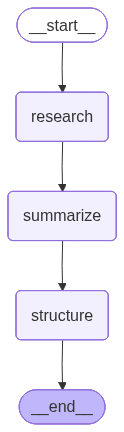

In [18]:
# pplot graph
# research_graph.plot_graph()

from IPython.display import Image

# graph = build_graph()
Image(research_graph.get_graph().draw_mermaid_png())